In [1]:
import xarray as xr
import rioxarray as rix
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt

### 1. Prepare DEM data

In [2]:
elevation_raster = rix.open_rasterio("../data/east_river_elevation.tif")

In [3]:
print(elevation_raster.rio.crs)

EPSG:32613


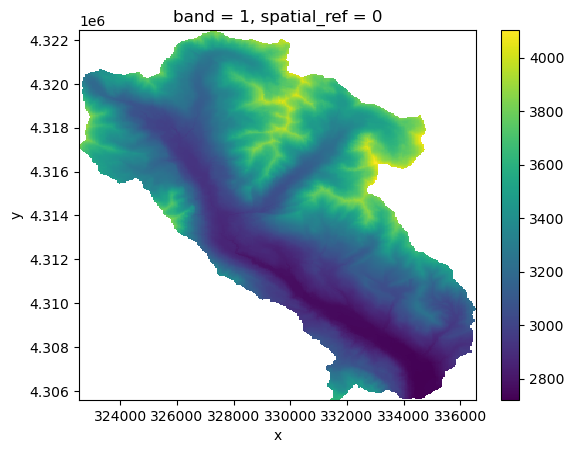

In [4]:
elevation_raster = rix.open_rasterio("../data/openamundsen/dem_uppereastriver_50.asc")
elevation_raster.plot()

### 2. Prepare ROI data, clip and save DEM

Create a raster mask using the ASC DEM and the Upper East River polygon

In [5]:
upper_east_river_polygon = gpd.read_file("../data/east_polygon.json").to_crs(
    elevation_raster.rio.crs
)

<Axes: title={'center': 'band = 1, spatial_ref = 0'}, xlabel='x', ylabel='y'>

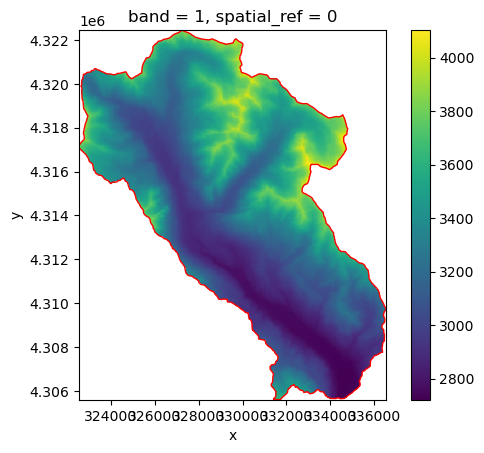

In [6]:
fig, ax = plt.subplots()
elevation_raster.plot(ax=ax)
upper_east_river_polygon.plot(edgecolor='red', facecolor='None', ax=ax)

In [7]:
elevation_raster = elevation_raster.rio.clip(upper_east_river_polygon.geometry, drop=True)

<Axes: title={'center': 'band = 1, spatial_ref = 0'}, xlabel='x coordinate of projection\n[metre]', ylabel='y coordinate of projection\n[metre]'>

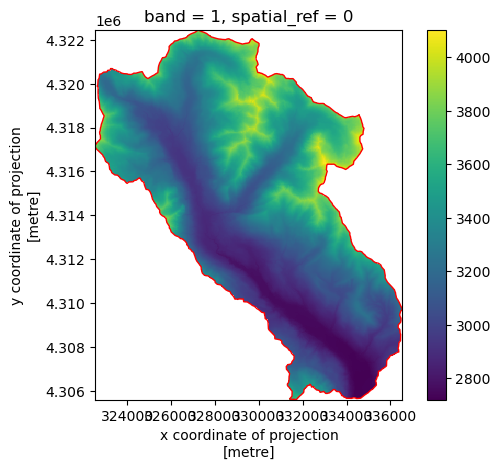

In [8]:
fig, ax = plt.subplots()
elevation_raster.plot(ax=ax)
upper_east_river_polygon.plot(edgecolor='red', facecolor='None', ax=ax)

In [9]:
elevation_raster.rio.to_raster(
    "../data/openamundsen/dem_uppereastriver_50.asc", driver='AAIGrid'
)

The file `dem_uppereastriver_50.asc` can be used by openamundsen.

Create the mask by doing some clipping with the geometry

In [10]:
in_bounds = (~ np.isnan(elevation_raster)).astype(int)
in_bounds.values = np.nan_to_num(in_bounds.values)

In [11]:
in_bounds.attrs = {}

In [12]:
in_bounds.rio.to_raster(
    "../data/openamundsen/roi_uppereastriver_50.asc", driver='AAIGrid'
)

The file `roi_uppereastriver_50.asc` can be used by openamundsen.

# Prepare met inputs

Open the two datasets

In [ ]:
inputs_ds = xr.open_dataset('../data/sos_full_dataset_30min.nc')

inputs_precip_df = pd.read_csv('../data/kettle_ponds_precip_30min.csv')
inputs_precip_df = inputs_precip_df.set_index('time')
inputs_precip_df.index = pd.to_datetime(inputs_precip_df.index)
inputs_precip_df['isnan'] = np.isnan(inputs_precip_df['precip_rate']).astype('int')

In [ ]:
inputs_precip_df.plot()
plt.xlim('20230310', '20230312')

In [ ]:
inputs_precip_df.plot()
plt.xlim('20230421', '20230424')

Get the met inputs we need from SOS measurements

In [ ]:
inputs_df = inputs_ds[[
    'T_3m_c',
    'RH_3m_c',
    'Rsw_in_9m_d',
    'spd_3m_c'
]].to_dataframe()

Merge the SOS measurements with the SAIL laser disdrometer precipitation

In [ ]:
inputs_df = inputs_df.join(inputs_precip_df, how='inner')

Rename the input variables to match the requirements

In [ ]:
inputs_df = inputs_df.rename(columns={
    'T_3m_c':       'temp',
    'RH_3m_c':      'rel_hum',
    'Rsw_in_9m_d':  'sw_in',
    'spd_3m_c':     'wind_speed',
    'precip_rate':  'precip',
})

Fill nans with forward filling

In [ ]:
inputs_df = inputs_df.fillna(0)

Convert temp from ˚C to K

In [ ]:
inputs_df['temp'] = inputs_df['temp'] + 273.15

Convert precip in rate of mm/hr to precipitation sum per interval in units kg/m^2 (same as mm)

In [ ]:
from metpy.units import units
from metpy.constants import density_ice, density_water

In [ ]:
inputs_df['precip'].max()

In [ ]:
new_precip_values = (
    (    
        (
            inputs_df['precip'].values * units ("mm/hr")
        ).to(units("mm / (30 minutes)")) * 30*units("minutes")
    ) * density_ice
).to(units("kg/m^2")).magnitude
inputs_df['precip'] = new_precip_values

In [ ]:
inputs_df['precip'].max()

# APPLY ADJUSTMENT FACTOR TO PRECIP SO THE VALUES AREN'T WILD OUT HERE!

The disdrometer data is way off

In [ ]:
(inputs_df['precip']).cumsum().plot()
(inputs_df['precip']*0.7).cumsum().plot()

In [ ]:
inputs_df['precip'] = inputs_df['precip']*0.7*0.5

In [ ]:
(inputs_df['precip']).cumsum().plot()

name the index `date`

In [ ]:
inputs_df.index.name = 'date'

Convert to UTC, remove dates from around daylight savings time in november b/c it messes things up

In [ ]:
inputs_df = inputs_df.loc["2022-11-10": "2023-06-15"]
inputs_df.index = inputs_df.index.tz_localize('US/Mountain').tz_convert('UTC').tz_localize(None)

Check that all timestamps are evenly spaced

In [ ]:
index_diff = inputs_df.loc["2022-11-16": "2023-06-15"].index.diff()
index_diff.value_counts()

Save inputs to a file

In [ ]:
inputs_df = inputs_df.reset_index()

In [ ]:
inputs_df.to_csv("../data/openamundsen/1.csv", index=False)

The file `kps_model_met.csv` can be used by openamundsen.

# Prepare stations.csv file

In [ ]:
elevation_raster.sel(
        x=329008.940,
        y=4312170.815,
        method='nearest'
    ).values.item()

In [ ]:
stations_df = pd.DataFrame({
    'id':      ["1"], # needs to match filename containing met data
    'name':    ["kps"],
    'x':       [329009],      # x coord for KPS in proper CRS
    'y':       [4312171],     # y coord for KPS in proper CRS
    'alt':     ["2858"],
})

stations_df

In [ ]:
stations_df.to_csv("../data/openamundsen/stations.csv", index=False)

# Summary

We created the files:

In [ ]:
ls ../data/openamundsen/

# Check out some sample files

In [ ]:
src = pd.read_csv("/Users/elischwat/Downloads/2023-037_Data_Rofental_UIBK/1_BellaVista_10min_2015-2023.csv", skiprows=2)

In [ ]:
src